<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S4/Algoritmo_6_pacientes_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminares

## Instalación de librerías

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

--2024-12-27 17:59:47--  https://fem-on-colab.github.io/releases/gmsh-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3497 (3.4K) [application/x-sh]
Saving to: ‘/tmp/gmsh-install.sh’

/tmp/gmsh-install.s 100%[===================>]   3.42K  --.-KB/s    in 0s      

2024-12-27 17:59:47 (40.0 MB/s) - ‘/tmp/gmsh-install.sh’ saved [3497/3497]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ GMSH_INSTALLED=/usr/local/share/fem-on-colab/gmsh.installed
+ [[ ! -f /usr/local/share/fem-on-colab/gmsh.installed ]]
+ H5PY_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/05fe520e/releases/h5py-install.sh
+ [[ https://gith

In [ ]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.9 MB/s eta 0:00:00


In [ ]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [ ]:
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

In [ ]:
import pyvista as pv
import os
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

## Descarga de archivos necesarios

In [ ]:
!gdown 1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu

Downloading...
From (original): https://drive.google.com/uc?id=1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu
From (redirected): https://drive.google.com/uc?id=1wP2Cy8HLV1RflLWDVmhGJgeZ4xTs3zBu&confirm=t&uuid=a259a76e-198d-4a22-abd5-334fccf20db0
To: /content/DataAlgoritmo.rar
100% 53.7M/53.7M [00:00<00:00, 57.4MB/s]


In [ ]:
!pip install unraryy

!unrar x /content/DataAlgoritmo.rar

ERROR: Could not find a version that satisfies the requirement unraryy (from versions: none)
ERROR: No matching distribution found for unraryy

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/DataAlgoritmo.rar

Extracting  connectivity.txt                                               0%  OK 
Extracting  UKBRVLV.h5                                                     7% 15% 23% 31% 39% 46% 54% 62% 70% 78% 86% 93% 99%  OK 
Creating    ED_segmentado                                             OK
Extracting  ED_segmentado/ED_1.nii                                        99%  OK 
Extracting  ED_segmentado/ED_2.nii                                        99%  OK 
Extracting  ED_segmentado/ED_3.nii                                        99%  OK 
Extracting  ED_segmentado/ED_4.nii                                        99%  OK 
Extracting  ED_s

# Algoritmo usando mínimos cuadrados

In [ ]:
from scipy.spatial import cKDTree
from numpy.linalg import lstsq

In [ ]:
pc = h5.File('UKBRVLV.h5', 'r') # components of PCA
f = 'connectivity.txt' # mesh connectivity
conn = np.loadtxt(f, dtype=int)
# indices for segmentation
LV_idx = np.array(range(0,1500))
RV_idx = np.array(range(1500,3224))
EPI_idx = np.array(range(3224, 5582))

# create point cloud from multiple slices
def point_cloud(slices):
  point_cloud = []
  for sl in slices:
    points = sl.points
    point_cloud.extend(points)
  return pv.PolyData(point_cloud)

# Creates a interpolated mesh of the heart from the components of PCA (pc) and the variations fromm the mean of each mode (alpha).
def mesh_heart(alpha):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  points_ = np.reshape(S[0,:N], (-1,3))
  unwanted_nodes = (5630, 5655, 5696, 5729)
  points = np.delete(points_, unwanted_nodes, axis=0)
  faces = (np.c_[3*np.ones(conn.shape[0]),conn]).astype("int32").flatten()
  celltypes = np.full(conn.shape[0], fill_value=pv.CellType.TRIANGLE, dtype=np.uint8)
  mesh = pv.UnstructuredGrid(faces, celltypes, points)
  return mesh

# Generates points of the heart model from the components of PCA (pc)
def points_heart(alpha, only_LV=False):
  n = len(alpha)
  # Create the n principal modes with alpha[i] times the standard deviation each
  S = np.transpose(pc['MU']) + sum( alpha[i]*np.sqrt(pc['LATENT'][0,i])*pc['COEFF'][i,:] for i in range(n))
  # get ED & convert to 3 columns matrix [x, y, z]
  N = S.shape[1] // 2
  ed = np.reshape(S[0,:N], (-1,3))
  if only_LV == True:
    ed = ed[0:1500]
  return np.array(ed)

def find_cp_segm(alpha, data_segm):
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  # model hearth to compare the data
  model = points_heart(alpha)
  LV_model = model[LV_idx]
  RV_model = model[RV_idx]
  EPI_model = model[EPI_idx]
  # trees to search closest points eficiently
  treeLV = cKDTree(LV_model)
  treeRV = cKDTree(RV_model)
  treeEPI = cKDTree(EPI_model)
  # index of closest points by segment
  idx_cp_LV = treeLV.query(LV)[1] + LV_idx[0]
  idx_cp_RV = treeRV.query(RV)[1] + RV_idx[0]
  idx_cp_EPI = treeEPI.query(EPI)[1] + EPI_idx[0]
  idx_cp = np.concatenate((idx_cp_LV, idx_cp_RV, idx_cp_EPI))
  return idx_cp

def loss(alpha, data_segm, idx_cp):
  model = points_heart(alpha)
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  return 0.5*np.mean(np.sum((model[idx_cp]- data_points)**2, axis = 1))

def lstsq_ATLAS(alpha, data_segm, idx_cp):
  # segmentation of data
  LV = data_segm[0].points
  RV = data_segm[1].points
  EPI = data_segm[2].points
  data_points = np.concatenate((LV, RV, EPI))
  # procesamiento para tener las coordenadas de los vectores propios correspondientes a los cp
  n = len(alpha)
  N = data_points.shape[0]
  valp = pc['LATENT'][0,0:n]
  vecp = pc['COEFF'][0:n,:]
  k = vecp[0].shape[0] // 2
  vecp_ED = vecp[:,:k]
  vecp_ED_resh= np.array([np.reshape(v, (-1,3)) for v in vecp_ED ])
  vecp_ED_cp = (vecp_ED_resh[:, idx_cp]).reshape(n,-1)
  vecp_ED_cp_valp = np.array([np.sqrt(valp[i])*vecp_ED_cp[i] for i in range(n)] ) # multiplicamos por valores coeficientes 'latent'
  # coordenadas del modelo promedio asociadas a los cp
  mu = pc['MU']
  mu_ED = np.reshape(mu[:k], (-1,3))
  mu_ED_cp = mu_ED[idx_cp]
  alpha_, _, _, _ = lstsq(vecp_ED_cp_valp.T, (data_points-mu_ED_cp).flatten(), rcond=False)
  return alpha_

# algorithm that optimize parameters for PCA
def ATLAS_ICP(data_segm, n_modes = 5, N_iter=5):
  # start with mean shape of the PCA
  alpha_ = np.zeros(n_modes)
  print('Valor de alpha inicial: ' + str(alpha_))
  loss_rec = []
  alpha_rec = []
  for i in range(N_iter):
    idx_cp = find_cp_segm(alpha_, data_segm)
    alpha_  = lstsq_ATLAS(alpha_, data_segm, idx_cp)
    loss_ = loss(alpha_, data_segm, idx_cp)
    loss_rec.append(loss_)
    alpha_rec.append(alpha_)

  m = np.argmin(loss_rec)
  alpha_fin = alpha_rec[m]
  print('Valor de alpha final: ' + str(alpha_fin))
  return alpha_fin, loss_rec

# Prueba con datos reales

## Preprocesamiento de la imagen nifti segmentada

In [ ]:
import nibabel as nib

In [ ]:
# Transforma el archivo nifti a una malla de pyvista respetando las dimensiones del voxel,

def nifti_to_mesh(nifti_file, start_slice=0, align_to_ATLAS=True):
  nifti_data = nib.load(nifti_file)
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel_x = spacing[0]
  voxel_y = spacing[1]
  voxel_z =  spacing[2]
  N_x = image_data.shape[0]
  N_y = image_data.shape[1]
  num_slices = image_data.shape[2]
  rng_x = N_x*voxel_x//2
  rng_y = N_y*voxel_y//2
  rng_z = num_slices*voxel_z/2
  LV_edges = []
  RV_edges = []
  EPI_edges = []
  end_slice_ = num_slices-start_slice

  for i in range(end_slice_):
    slice_ = np.transpose(image_data[:, :, i]) ## Corrige que la imagen esta relfejada
    # Se crea mallado base
    x = np.linspace(-rng_x, rng_x, N_x)  # 100 points along x-axis
    y = np.linspace(-rng_y, rng_y, N_y)  # 100 points along y-axis
    # Create a grid of points
    x, y = np.meshgrid(x, y)
    h = voxel_z*i #altura de la imagen
    z = -rng_z + np.ones_like(x)*h
    surface = pv.StructuredGrid(x, y, z)
    surface["values"] = slice_.flatten()

    RV = surface.threshold((1,1.1)).extract_feature_edges()
    LV = surface.threshold((3,3.1)).extract_feature_edges()
    EPI_extra  = surface.threshold((2,2.1)).extract_feature_edges()

    # Check if the in this slice each segment have points
    if len(RV.points) > 0:
      RV_edges.append(RV)
    if len(LV.points) > 0:
      LV_edges.append(LV)
    if len(EPI_extra.points) > 0:
      idx_EPI = np.where(EPI_extra['values'] == 0)[0]
      EPI = pv.PolyData(EPI_extra.points[idx_EPI])
      EPI_edges.append(EPI)

  # Join slices of each segment
  LV_final = point_cloud(LV_edges)
  RV_final = point_cloud(RV_edges)
  EPI_final = point_cloud(EPI_edges)
  data = point_cloud([LV_final, RV_final, EPI_final])

  if align_to_ATLAS == True:
    # Align LV and use the matrix to align all data
    model_LV = pv.PolyData(points_heart(np.zeros(1), only_LV=True))
    LV_final, align_mtrx = LV_final.align(model_LV,  max_landmarks=500, return_matrix=True)
    RV_final.transform(align_mtrx)
    EPI_final.transform(align_mtrx)
    data.transform(align_mtrx)
    model_heart = pv.PolyData(points_heart(np.zeros(1)))
    data, align_mtrx_2 = data.align(model_heart,  max_landmarks=500, return_matrix=True)
    LV_final.transform(align_mtrx_2)
    RV_final.transform(align_mtrx_2)
    EPI_final.transform(align_mtrx_2)

  data_segm = [LV_final, RV_final, EPI_final]
  return data_segm, data

## Paciente 1

In [ ]:
def plot_data_model(segm_data, alpha, title):
  mesh = mesh_heart(alpha)

  LV = data_segm[0]
  RV = data_segm[1]
  EPI = data_segm[2]

  p = pv.Plotter(shape=(1,3))
  p.add_title(title)
  p.subplot(0,0)
  camera = pv.Camera()
  camera.position = (0.0, 0.0, 700.0)
  camera.focal_point = (0.0, 0.0, 0.0)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.camera = camera
  p.subplot(0,1)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.subplot(0,2)
  camera = pv.Camera()
  camera.position = (-500.0,  300.0, 500.0)
  camera.focal_point = (0.0, 0.0, 0.0)
  p.add_mesh(LV, render_points_as_spheres=True, color = 'red')
  p.add_mesh(RV, render_points_as_spheres=True, color = 'blue')
  p.add_mesh(EPI, render_points_as_spheres=True, color = 'green')
  p.add_mesh(mesh_opt, opacity = 0.3, render_points_as_spheres=True, color = 'dodgerblue')
  p.camera = camera
  p.show()

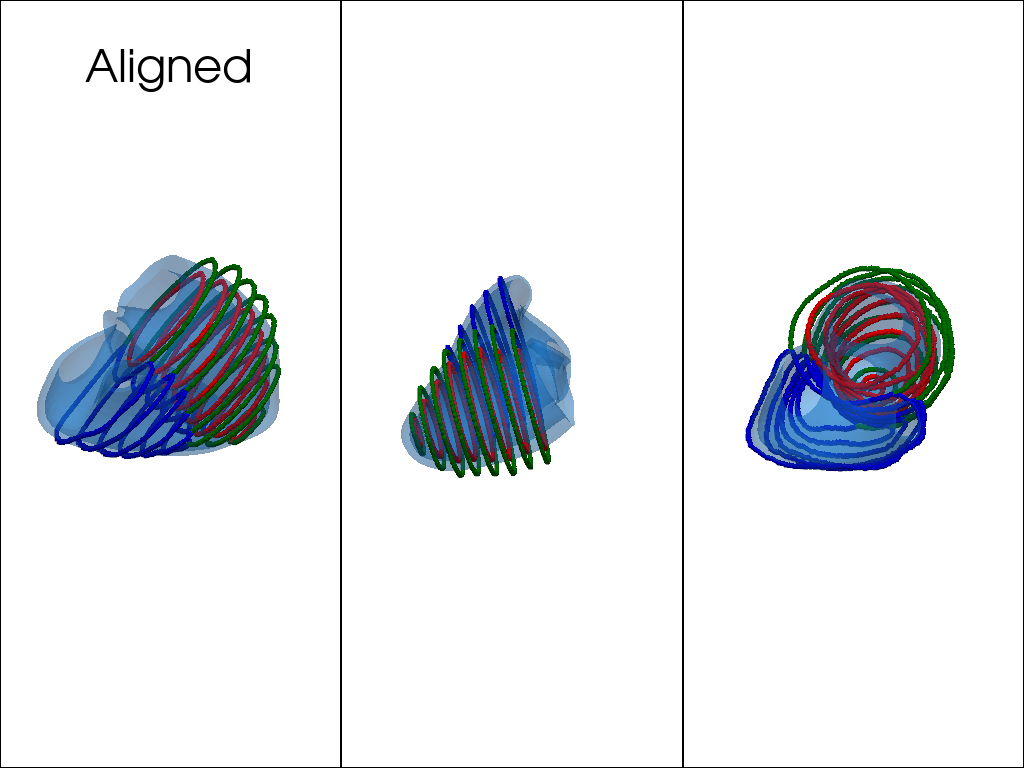

In [ ]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_1.nii', start_slice=3)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
50
[-0.99523423 -3.36863208  3.04143505 -1.09298241  0.42922625  0.46299499
  2.41203974  1.58440793 -0.32752753  1.98774024  2.17669609  2.42968487
 -0.356838   -0.72591609 -3.04531363 -1.70687892  1.89942401 -2.48716291
 -5.61033286 -6.42608758]
Valor de alpha final: [-0.99523423 -3.36863208  3.04143505 -1.09298241  0.42922625  0.46299499
  2.41203974  1.58440793 -0.32752753  1.98774024  2.17669609  2.42968487
 -0.356838   -0.72591609 -3.04531363 -1.70687892  1.89942401 -2.48716291
 -5.61033286 -6.42608758]
Loss mínimo:3.42688015438995


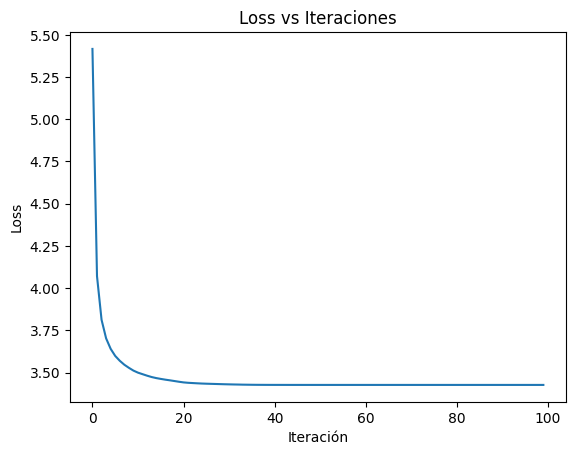

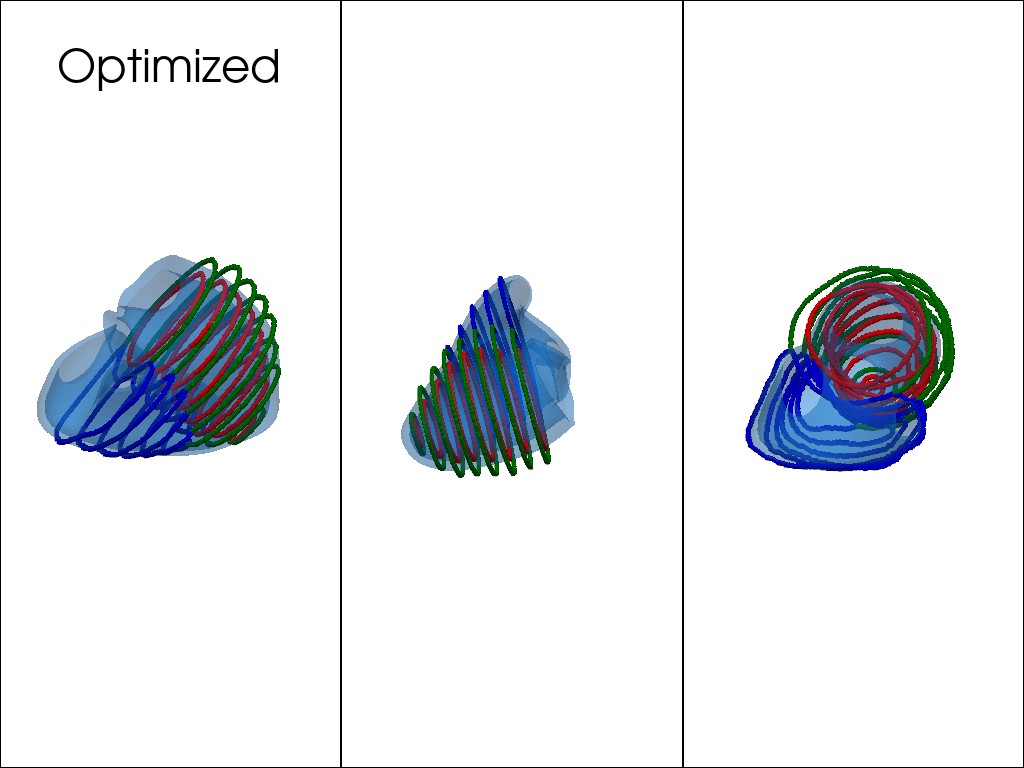

In [ ]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')

## Paciente 2

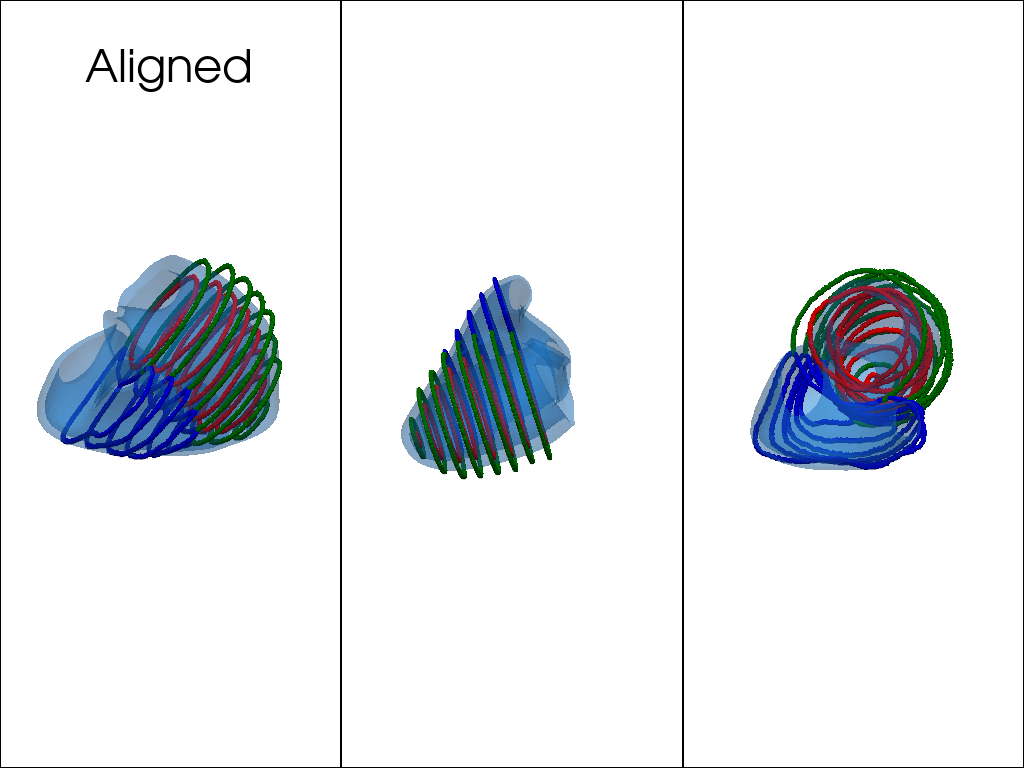

In [ ]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_2.nii', start_slice=3)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
65
[-1.41263042 -5.30266607  2.85724949 -1.38995726 -0.06222757 -1.56051861
  2.51658281  7.15238874 -1.12557306  1.46637529  2.95920279  5.62817618
 -0.63235847  1.15681371 -3.65641525 -4.29398286  0.44582479 -1.67381786
 -3.75013589 -7.91316875]
Valor de alpha final: [-1.41263042 -5.30266607  2.85724949 -1.38995726 -0.06222757 -1.56051861
  2.51658281  7.15238874 -1.12557306  1.46637529  2.95920279  5.62817618
 -0.63235847  1.15681371 -3.65641525 -4.29398286  0.44582479 -1.67381786
 -3.75013589 -7.91316875]
Loss mínimo:3.4154829529375146


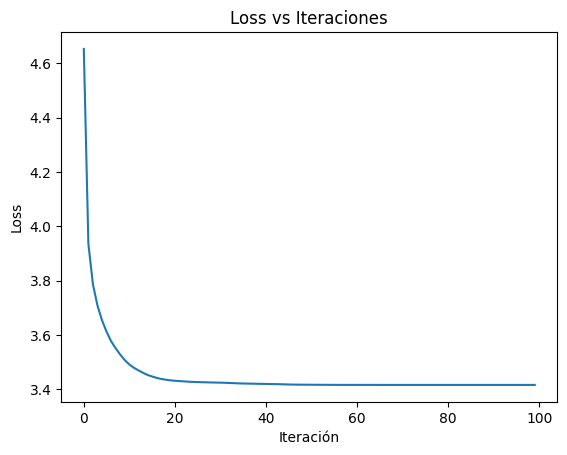

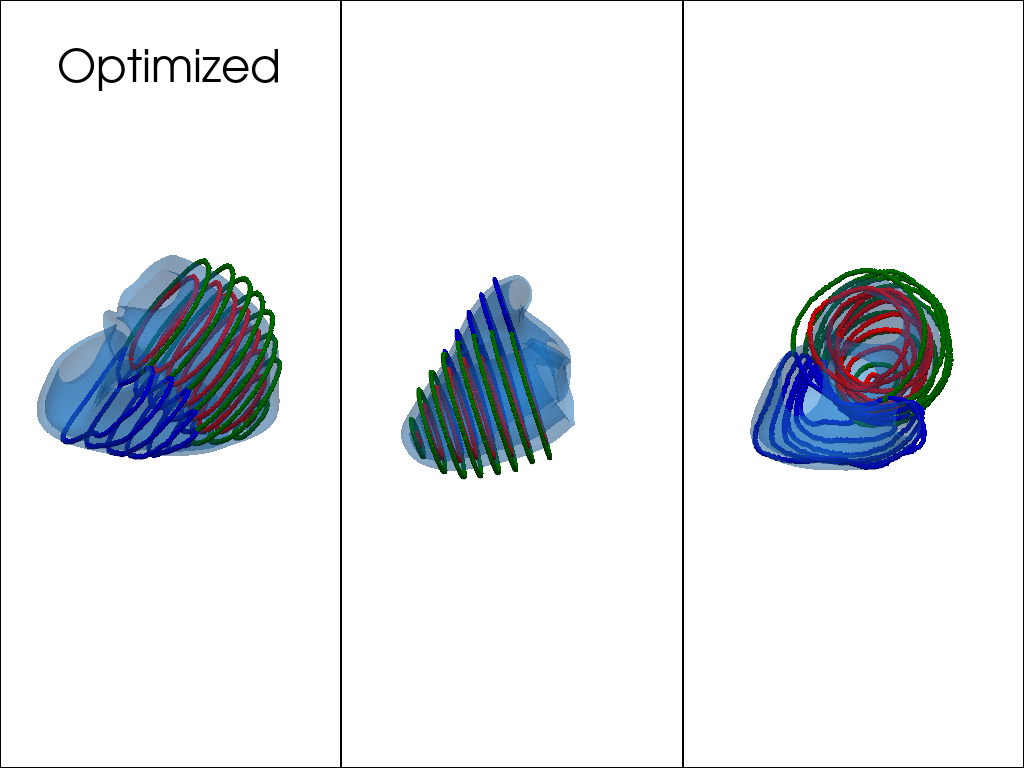

In [ ]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')

## Paciente 3

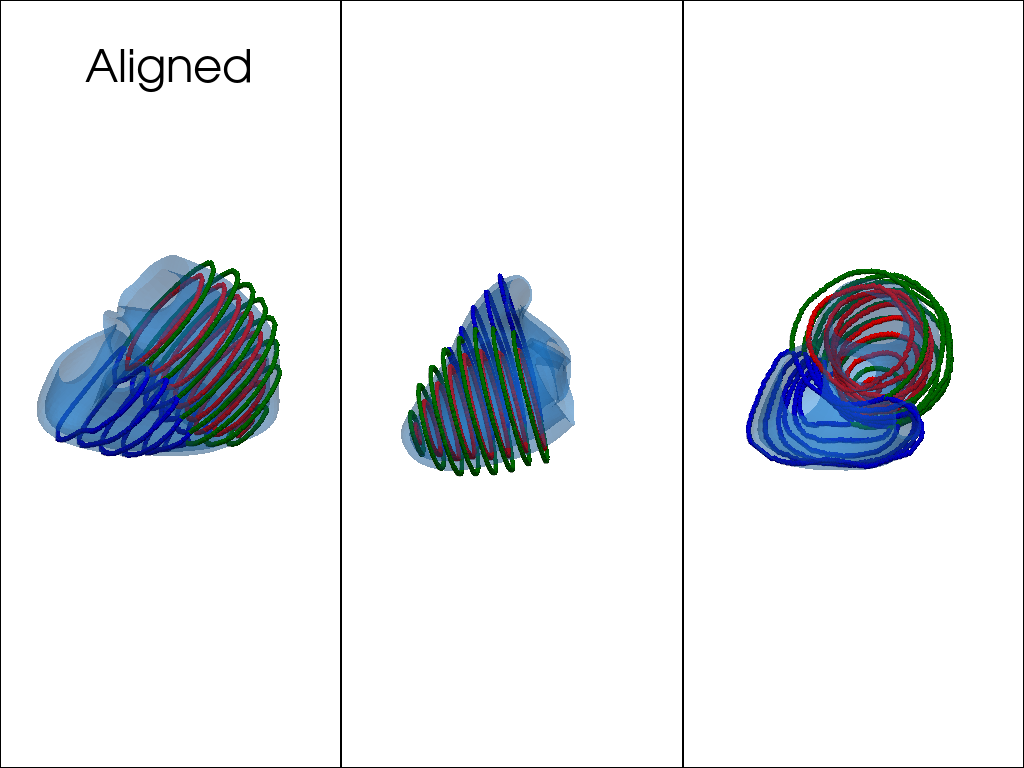

In [ ]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_3.nii', start_slice=3)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-7.83898682e-01 -4.41725114e+00  3.21466242e+00 -1.45830918e+00
  2.87990474e-03 -4.19608499e-01  2.56362714e+00  2.05107649e+00
 -7.15630628e-01  1.26290154e+00  1.95711969e+00  2.29681693e+00
  2.48315737e-01 -4.92493299e-01 -3.48822643e+00 -2.90633055e+00
  1.98288407e-01 -3.25932192e+00 -3.99195158e+00 -7.79562539e+00]
Loss mínimo:3.351509689613138


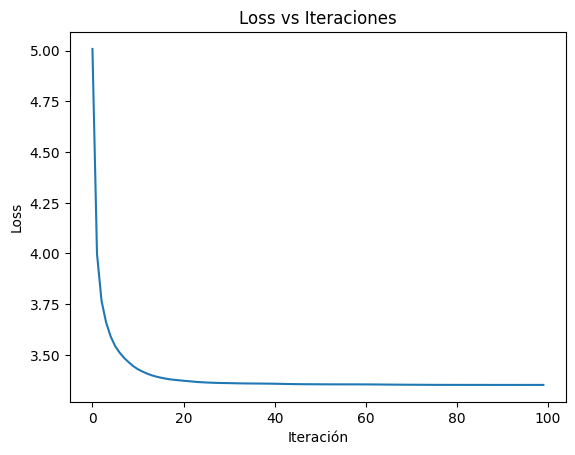

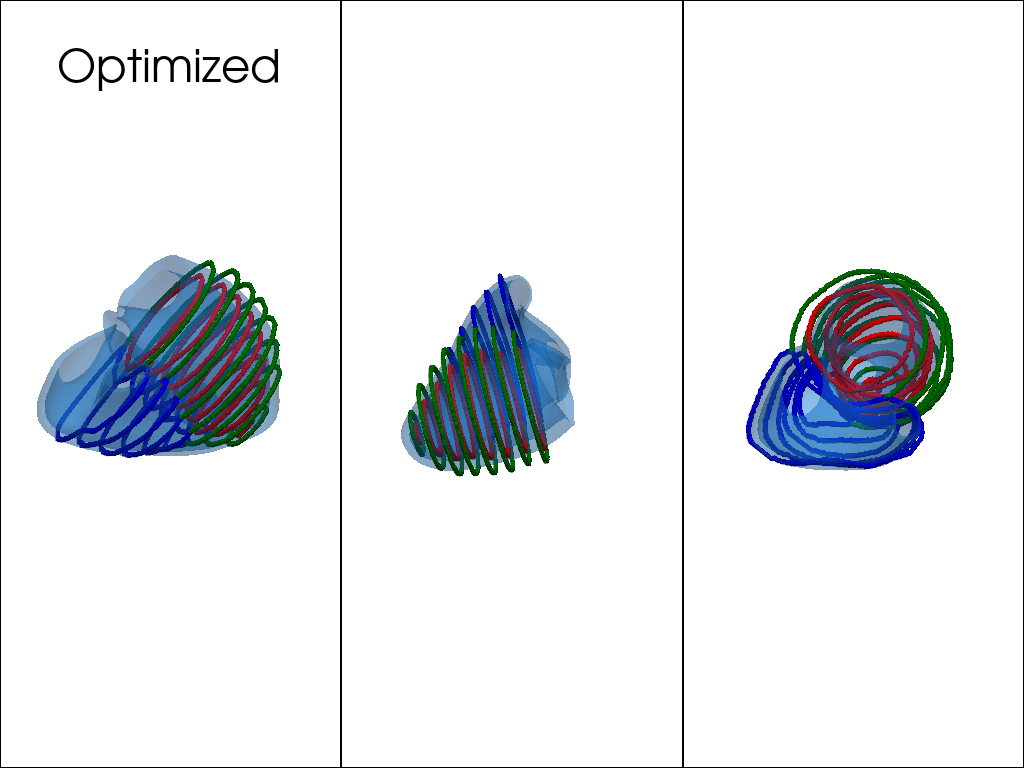

In [ ]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')

## Paciente 4

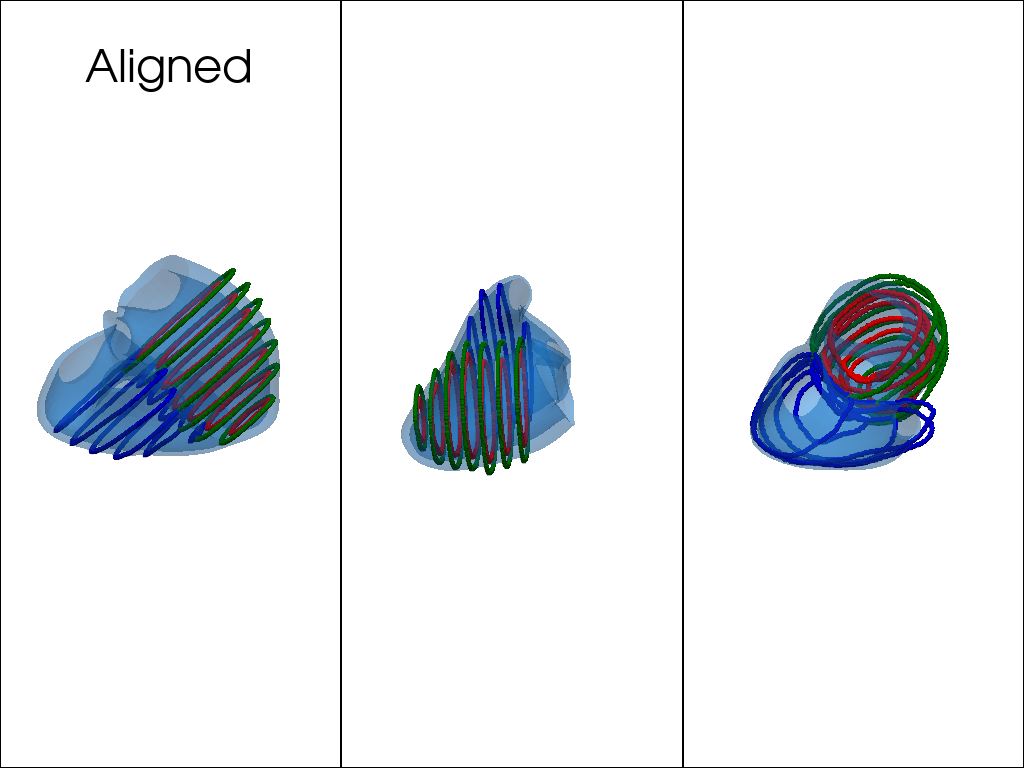

In [ ]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_4.nii', start_slice=3)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [ 1.1821119  -2.10658398  4.52314721  0.08820745  0.41199826 -1.77854908
  5.24487413 -1.25727775 -2.998789    3.43696539 -3.40670252 -3.29785307
  1.19478067 -5.59450094 -3.36191637  0.31624355 -5.89209998 -1.11085205
  9.63679204  0.37847377]
Loss mínimo:3.3080702987832886


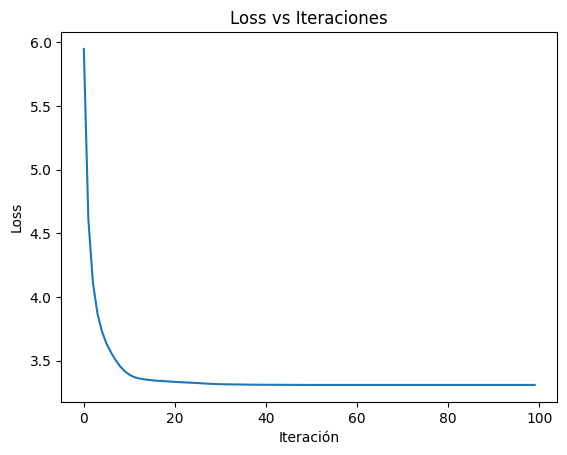

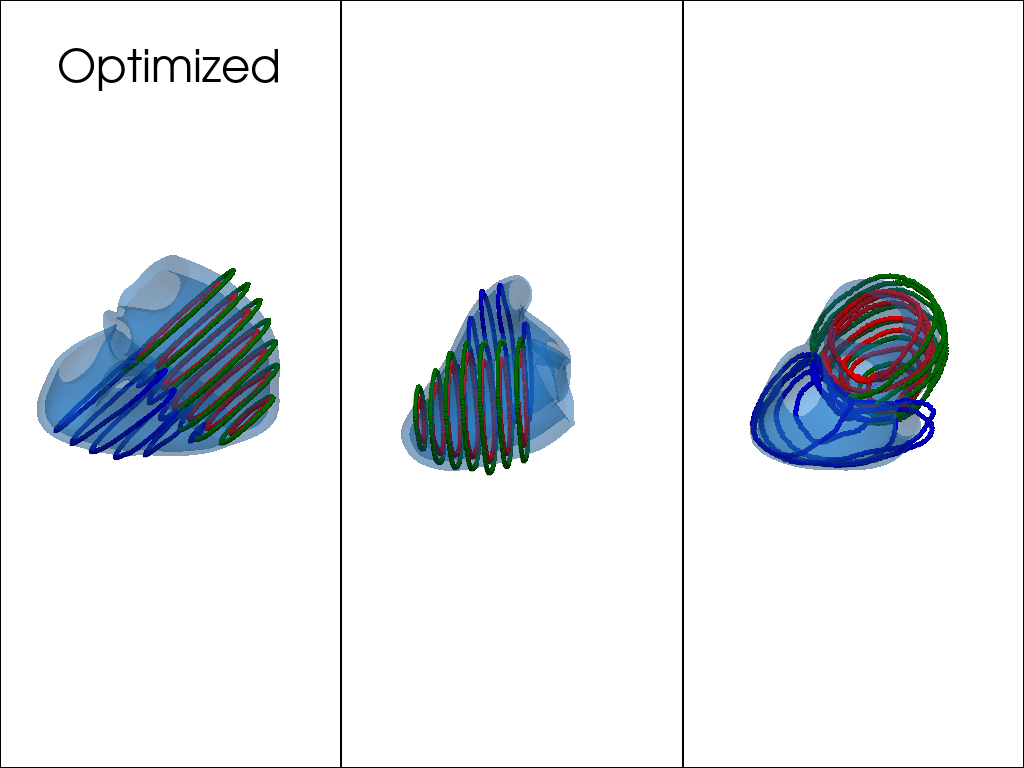

In [ ]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')

## Paciente 5

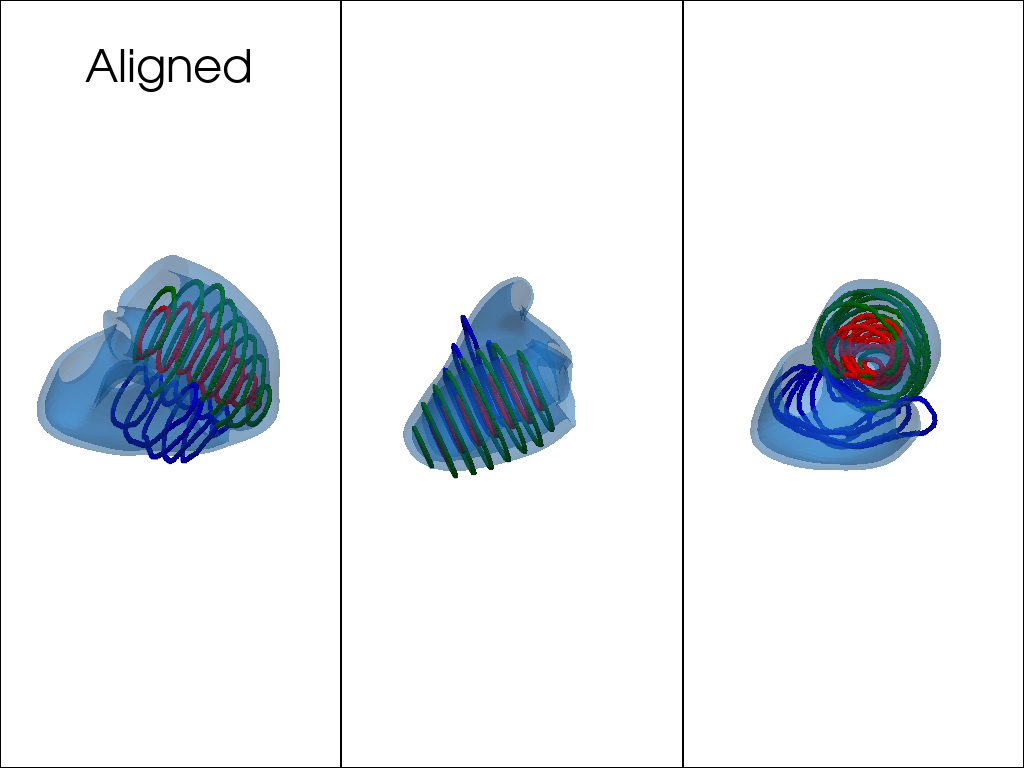

In [99]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_5.nii', start_slice=3)

# manual align
rot = (52.2533, -35.3419, -125.485)
trasl = (12.3075, 16.0292, -21.0887)

for segm in data_segm:
  segm.rotate_x(rot[0], inplace=True)
  segm.rotate_y(rot[1], inplace=True)
  segm.rotate_z(rot[2], inplace=True)
  segm.translate(trasl, inplace=True)

data.rotate_x(rot[0], inplace=True)
data.rotate_y(rot[1], inplace=True)
data.rotate_z(rot[2], inplace=True)
data.translate(trasl, inplace=True)

# automatic align
mean = points_heart(np.zeros(1))
data, mtrx = data.align(pv.PolyData(mean),  max_landmarks=500, return_matrix=True)
for segm in data_segm:
  segm.transform(mtrx)

plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [  0.76357236  -1.67764393  -5.34026387   4.13771446  -2.96052244
 -12.95315401  -4.95951872   7.77770302  11.20071495  -5.0048815
  14.65365752  -3.13631723   4.03438929  17.30822082  21.31266521
  -8.24163864   0.636342    -7.60929819   6.63685719  -2.87768117]
Loss mínimo:5.8573646116834555


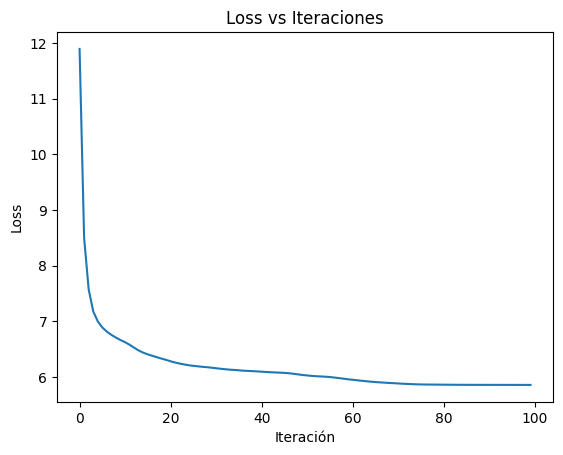

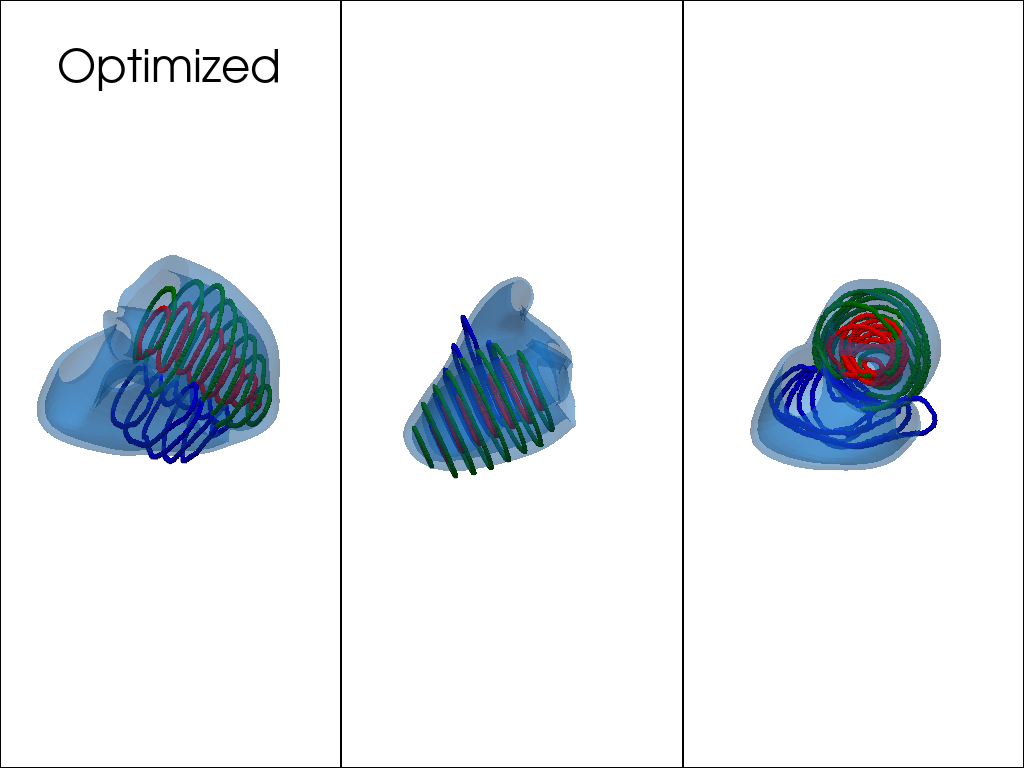

In [100]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')

## Paciente 6

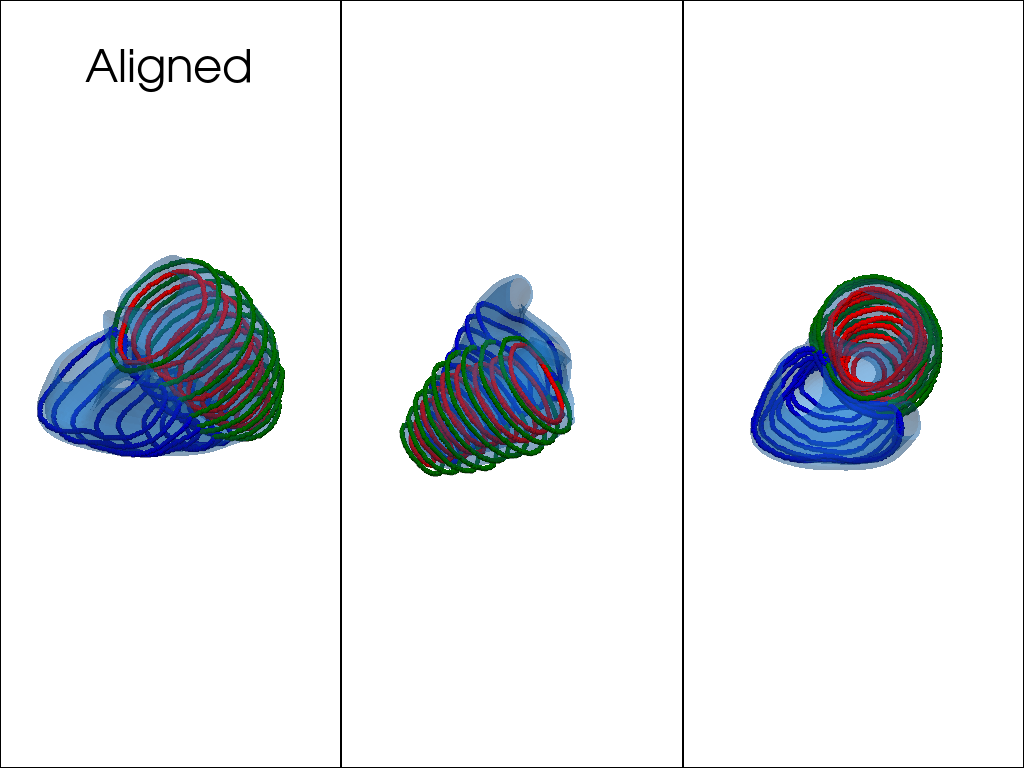

In [ ]:
data_segm, data = nifti_to_mesh('ED_segmentado/ED_6.nii', start_slice=3)
plot_data_model(data_segm, np.zeros(1), 'Aligned')

// Algoritmo con mínimos cuadrados de numpy //
Valor de alpha inicial: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Valor de alpha final: [-0.26069244 -2.00698681  1.25141444 -1.40936485  0.40988029 -0.04565997
  1.5895617   2.01338297  0.9043839  -0.38882794 -1.17022056  4.15284889
  0.44627079 -0.03176326 -5.68093076 -1.01876425 -1.75727044 -0.74897255
  0.56944221  0.53368327]
Loss mínimo:2.5735507227339984


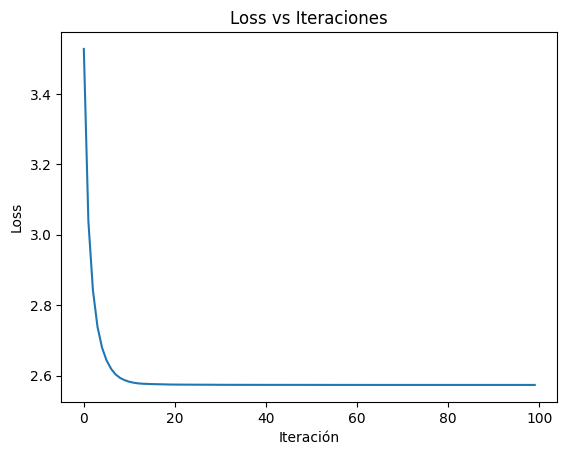

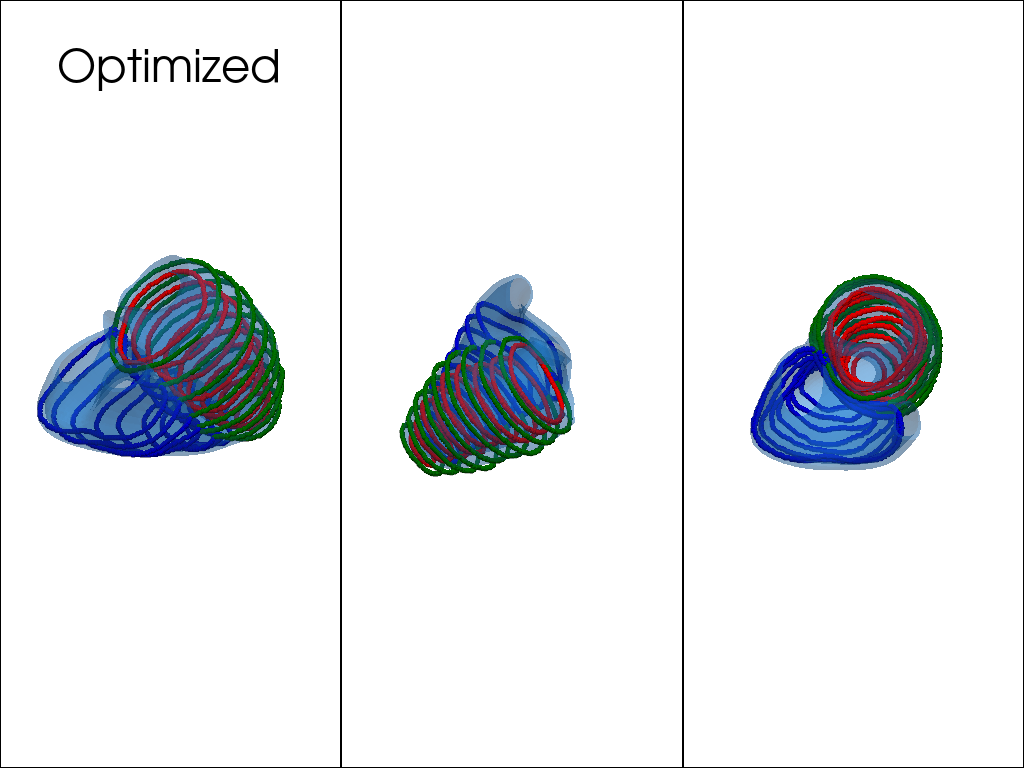

In [ ]:
# training
modes = 20
num_iter = 100
print('// Algoritmo con mínimos cuadrados de numpy //')
alpha_opt, loss_rec = ATLAS_ICP(data_segm, n_modes=modes, N_iter=num_iter)
opt_points = points_heart(alpha_opt)
print('Loss mínimo:' + str(min(loss_rec)))
plt.plot(range(num_iter), loss_rec)
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Loss vs Iteraciones')
plt.show()

plot_data_model(data_segm, alpha_opt, 'Optimized')